In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic
import sys; sys.path.insert(0, '/srv/one/zhutchen/paper3/codes/')
from survey_volume import solid_angle, integrate_volume, comoving_volume, comoving_volume_shell
import pickle

from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(70.,0.3,0.7)

def bin_bootstrap(vals):
    nbs = 5000
    data = np.random.choice(vals, size=(len(vals),5000))
    return np.std(np.median(data,axis=0))

mad = lambda xx: np.median(np.abs(xx-np.median(xx)))
def bin_bootstrap_mad(vals):
    nbs = 5000
    data = np.random.choice(vals, size=(len(vals),5000))
    return np.std([mad(row) for row in data])

In [2]:
data = pd.read_hdf("./zou/xmmservs_laduma_merged.hdf5")

# Derive Completeness Limit as $f(z)$

In [3]:
def peak_Mr_in_bin(Mr_values):
    bins=np.arange(-25,-5,0.1)
    hist,bedges=np.histogram(Mr_values,bins=bins)
    binc = 0.5*(bedges[1:]+bedges[:-1])
    return binc[np.argmax(hist)]

/tmp/ipykernel_3297485/320193914.py:24: RuntimeWarning: divide by zero encountered in log10
  limit = 26+5-5*np.log10(cosmo.luminosity_distance(zz).to_value()*1e6)


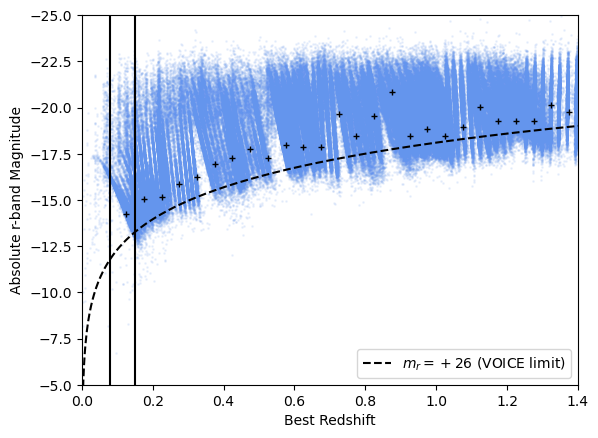

In [13]:
plt.figure()
sel = (data.absrmag!=-999) & ~pd.isna(data.absrmag) & ~pd.isna(data.bestoverallredshift) & (data.flag_star!=1)# & (data.Qz<1)
plt.scatter(data.bestoverallredshift[sel], data.absrmag[sel], s=1, color='cornflowerblue', alpha=0.1)


envelope, bedges, _ = binned_statistic(data.bestoverallredshift[sel], data.absrmag[sel], bins=np.arange(0.1,2.1,0.01), statistic=lambda x: np.percentile(x,99.7))
binc = 0.5*(bedges[1:]+bedges[:-1])



# model = lambda x, a, b, c: a+b/(x)+c/(x*x) 
# popt,pcov = curve_fit(model, binc, envelope)
# completeness_limit = lambda zv: model(zv,*popt)
# zz = np.linspace(0.05,2,1000)
# plt.plot(zz,completeness_limit(zz),'r')
# plt.plot(binc,envelope,'.',color='k')
# plt.axhline(-19.5,color='k',linestyle='dashed')

peaks, bedges, _ = binned_statistic(data.bestoverallredshift[sel], data.absrmag[sel], bins=np.arange(0.1,2.1,0.05), statistic=peak_Mr_in_bin)
binc = 0.5*(bedges[1:]+bedges[:-1])
plt.plot(binc,peaks,'+',markersize=4,color='k')

zz = np.linspace(0,2,1000)
limit = 26+5-5*np.log10(cosmo.luminosity_distance(zz).to_value()*1e6)
limit_fn = lambda zz_: 26+5-5*np.log10(cosmo.luminosity_distance(zz_).to_value()*1e6) 
plt.plot(zz, limit, 'k--', label=r'$m_r = +26$ (VOICE limit)')


plt.xlim(0,1.4)
plt.ylim(-5,-25)
plt.xlabel("Best Redshift")
plt.ylabel("Absolute r-band Magnitude")
plt.legend(loc='lower right')
plt.axvline(0.08, color='k')
plt.axvline(0.15, color='k')
plt.show()

# Create Volume-Limited Samples + Output

In [5]:
slice_boundaries = np.arange(0,1.2,0.1)

In [6]:
volumes=dict()
comp_limit=dict()
for ii in range(0,len(slice_boundaries)-2):#sliceID.max()): # don't use 0th bin since not really a bin
    subvolume = data[(data.bestoverallredshift>slice_boundaries[ii]) & (data.bestoverallredshift<=slice_boundaries[ii+2]) & ~pd.isna(data.mag_R_VOICE)]
    # plt.figure()
    # plt.plot(subvolume.RAall, subvolume.DECall, 'k.', alpha=0.2, markersize=1)
    # plt.grid()
    # plt.show()
    zmin,zmax=np.min(subvolume.bestoverallredshift),np.max(subvolume.bestoverallredshift)
    SA = solid_angle(subvolume.RAall, subvolume.DECall, bins=1000) / 3282.8 # convert from deg2 to steradians
    vol = integrate_volume(np.linspace(zmin,zmax,10000), SA, 70., 0.3, 0.7)
    print(zmin, zmax, SA, vol, len(subvolume))
    fname = "subvolume_{:0.1f}_to_{:0.1f}.hdf5".format(zmin,zmax)
    subvolume.to_hdf("/srv/one/zhutchen/paper3/data/subvolumes/"+fname, key='df')
    volumes[fname] = vol
    comp_limit[fname] = limit_fn(zmax)

9.890957430111133e-06 0.1999981713241345 0.0011555179132338765 209860.51996660192 53548


/tmp/ipykernel_3297485/2334935755.py:14: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['NED_NAME_zspecfile', 'refcode_zspecfile', 'NED_TYPE_zspecfile',
       'NED_FLAG_zspecfile', 'zrefcode_zspecfile', 'ID_2_zspecfile',
       'object_name_zspecfile', 'MASKNAME_zspecfile', 'SID_zspecfile',
       'CLASS_ATLAS_zspecfile', 'OBJNAME_6_zspecfile', 'SURVEY_zspecfile',
       'FIELD_zspecfile', 'MASK_zspecfile', 'CLASS_PRIMUS_zspecfile',
       'TARGET_BAND_zspecfile', 'ozdes_id_zspecfile', 'object_types_zspecfile',
       'transient_type_zspecfile', 'comment_zspecfile', 'spmask_obs_zspecfile',
       'det_zspecfile', 'id_iau_zspecfile', 'Tractor_ID_other', 'ztype',
       'leftgoodband', 'rightgoodband'],
      dtype='object')]

  subvolume.to_hdf("/srv/one/zhutchen/paper3/data/subvolumes/"+fname, key='df')


0.1000047570619822 0.3 0.0011676425510996659 634731.5386529368 71502
0.20000126756156505 0.4 0.0011468696672778688 1219720.4597164234 46936
0.30000130649738455 0.5 0.0011478245688203402 1925716.2415824647 44714
0.40001468414536145 0.5999971655316252 0.0011575849984762055 2703325.1440561973 53929
0.5000001094282986 0.7 0.0011705810269077377 3510412.543722985 76849
0.6000000238418579 0.8 0.0011672798069463108 4250295.589858348 71963
0.7000020750904314 0.9 0.0011556349420616236 4905682.824681588 53455
0.8000024465886406 1.0 0.001173398753335326 5632407.377795486 66753
0.9000047411587206 1.1 0.001183232407154391 6272660.134123637 95296


In [7]:
SPWs = np.array([
    [880,933],\
    [960,1161],\
    [1304,1420],\
])
SPWz = 1420/SPWs[::-1,::-1]-1
print(SPWz)

for (zlow, zhigh) in SPWz:
    subvolume = data[(data.bestoverallredshift>zlow) & (data.bestoverallredshift<=zhigh) & ~pd.isna(data.mag_R_VOICE)]
    # plt.figure()
    # plt.plot(subvolume.RAall, subvolume.DECall, 'k.', alpha=0.2, markersize=1)
    # plt.grid()
    # plt.show()
    zmin,zmax=np.min(subvolume.bestoverallredshift),np.max(subvolume.bestoverallredshift)
    SA = solid_angle(subvolume.RAall, subvolume.DECall, bins=500) / 3282.8 # convert from deg2 to steradians
    vol = integrate_volume(np.linspace(zmin,zmax,10000), SA, 70., 0.3, 0.7)
    print(zmin, zmax, SA, vol, len(subvolume))
    fname = "subvolume_{:0.3f}_to_{:0.3f}.hdf5".format(zmin,zmax)
    subvolume.to_hdf("/srv/one/zhutchen/paper3/data/subvolumes/"+fname, key='df')
    volumes[fname] = vol
    comp_limit[fname] = limit_fn(zmax)

[[0.         0.08895706]
 [0.22308355 0.47916667]
 [0.52197213 0.61363636]]
9.890957430111133e-06 0.08895236705868285 0.0009802692837011277 16987.45640027093 5627


/tmp/ipykernel_3297485/2882836328.py:20: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['NED_NAME_zspecfile', 'refcode_zspecfile', 'NED_TYPE_zspecfile',
       'NED_FLAG_zspecfile', 'zrefcode_zspecfile', 'ID_2_zspecfile',
       'object_name_zspecfile', 'MASKNAME_zspecfile', 'SID_zspecfile',
       'CLASS_ATLAS_zspecfile', 'OBJNAME_6_zspecfile', 'SURVEY_zspecfile',
       'FIELD_zspecfile', 'MASK_zspecfile', 'CLASS_PRIMUS_zspecfile',
       'TARGET_BAND_zspecfile', 'ozdes_id_zspecfile', 'object_types_zspecfile',
       'transient_type_zspecfile', 'comment_zspecfile', 'spmask_obs_zspecfile',
       'det_zspecfile', 'id_iau_zspecfile', 'Tractor_ID_other', 'ztype',
       'leftgoodband', 'rightgoodband'],
      dtype='object')]

  subvolume.to_hdf("/srv/one/zhutchen/paper3/data/subvolumes/"+fname, key='df')


0.22308383805751258 0.47915895215686344 0.0011844950903771444 2087100.535219917 57484
0.5219729984806327 0.613634075567062 0.0011566992263767491 1478262.8695118395 30232


In [8]:
pickle.dump(volumes, open('./subvolumes/volumes_h0.7.pkl','wb'))
volumes

{'subvolume_0.0_to_0.2.hdf5': 209860.51996660192,
 'subvolume_0.1_to_0.3.hdf5': 634731.5386529368,
 'subvolume_0.2_to_0.4.hdf5': 1219720.4597164234,
 'subvolume_0.3_to_0.5.hdf5': 1925716.2415824647,
 'subvolume_0.4_to_0.6.hdf5': 2703325.1440561973,
 'subvolume_0.5_to_0.7.hdf5': 3510412.543722985,
 'subvolume_0.6_to_0.8.hdf5': 4250295.589858348,
 'subvolume_0.7_to_0.9.hdf5': 4905682.824681588,
 'subvolume_0.8_to_1.0.hdf5': 5632407.377795486,
 'subvolume_0.9_to_1.1.hdf5': 6272660.134123637,
 'subvolume_0.000_to_0.089.hdf5': 16987.45640027093,
 'subvolume_0.223_to_0.479.hdf5': 2087100.535219917,
 'subvolume_0.522_to_0.614.hdf5': 1478262.8695118395}

In [9]:
pickle.dump(comp_limit, open('./subvolumes/completeness_h0.7.pkl','wb'))
comp_limit

{'subvolume_0.0_to_0.2.hdf5': -13.956258622536282,
 'subvolume_0.1_to_0.3.hdf5': -14.955460044114403,
 'subvolume_0.2_to_0.4.hdf5': -15.68446373148052,
 'subvolume_0.3_to_0.5.hdf5': -16.2611854215409,
 'subvolume_0.4_to_0.6.hdf5': -16.738979743381563,
 'subvolume_0.5_to_0.7.hdf5': -17.146895799269707,
 'subvolume_0.6_to_0.8.hdf5': -17.50256928302413,
 'subvolume_0.7_to_0.9.hdf5': -17.81764853923527,
 'subvolume_0.8_to_1.0.hdf5': -18.100237655543722,
 'subvolume_0.9_to_1.1.hdf5': -18.356225214029237,
 'subvolume_0.000_to_0.089.hdf5': -12.044778497588908,
 'subvolume_0.223_to_0.479.hdf5': -16.150427853516447,
 'subvolume_0.522_to_0.614.hdf5': -16.798242380270615}